# Deep cortical reinforcement learning: Policy gradients + Q-learning + GAN


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [63]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [64]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

# Discrete/int or continuos/float
env.action_space.dtype

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


dtype('float32')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [65]:
env.observation_space

Box(24,)

In [66]:
state = env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

In [67]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [68]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (24,))

In [69]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [70]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111, 24) (1111, 4) (1111, 24) (1111,)
dtypes: float64 float32 float64 float64
states: 0.9999491 -0.99980396
actions: 2.0423901875813804 -1.386185646057129
rewards: 2.0423901875813804 -1.386185646057129


In [71]:
actions[:10]

array([[ 2.74739973e-03, -1.31684646e-05,  1.02436312e-03,
        -1.59999108e-02,  9.19683278e-02, -1.35180948e-03,
         8.60266164e-01,  2.40187673e-03,  1.00000000e+00,
         3.23748849e-02, -1.35171739e-03,  8.53814155e-01,
         9.56013566e-04,  1.00000000e+00,  4.40814108e-01,
         4.45820212e-01,  4.61422890e-01,  4.89550292e-01,
         5.34102917e-01,  6.02461159e-01,  7.09149063e-01,
         8.85932028e-01,  1.00000000e+00,  1.00000000e+00],
       [ 1.81099847e-02,  2.27325392e-02,  1.50036299e-02,
         1.87298584e-02, -3.19512904e-01, -9.25155520e-01,
         1.48349273e+00,  9.93954817e-01,  1.00000000e+00,
         2.91940302e-01,  1.52260810e-01,  1.36669636e-01,
        -9.99908447e-01,  1.00000000e+00,  4.51477766e-01,
         4.56604987e-01,  4.72585082e-01,  5.01392901e-01,
         5.47023296e-01,  6.17035210e-01,  7.26303935e-01,
         9.07363415e-01,  1.00000000e+00,  1.00000000e+00],
       [ 3.07344068e-02,  2.62205172e-02,  1.24771661e

In [72]:
rewards[:10]

array([[ 1.81099847e-02,  2.27325392e-02,  1.50036299e-02,
         1.87298584e-02, -3.19512904e-01, -9.25155520e-01,
         1.48349273e+00,  9.93954817e-01,  1.00000000e+00,
         2.91940302e-01,  1.52260810e-01,  1.36669636e-01,
        -9.99908447e-01,  1.00000000e+00,  4.51477766e-01,
         4.56604987e-01,  4.72585082e-01,  5.01392901e-01,
         5.47023296e-01,  6.17035210e-01,  7.26303935e-01,
         9.07363415e-01,  1.00000000e+00,  1.00000000e+00],
       [ 3.07344068e-02,  2.62205172e-02,  1.24771661e-02,
        -8.54406476e-03, -8.12581480e-02, -8.26262236e-01,
         1.10302541e+00,  0.00000000e+00,  1.00000000e+00,
         3.13992411e-01,  3.77926439e-01,  4.68376875e-02,
        -1.00000008e+00,  0.00000000e+00,  4.53954518e-01,
         4.59109843e-01,  4.75177616e-01,  5.04143476e-01,
         5.50024211e-01,  6.20420158e-01,  7.30288327e-01,
         9.12341118e-01,  1.00000000e+00,  1.00000000e+00],
       [ 3.42181735e-02,  6.00428879e-03,  1.74115118e

In [73]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [74]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.8851764282630248, 0.20001739497735352)

In [75]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.020423901875813805 -0.013861856460571288


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [76]:
def model_input(state_size, action_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.float32, [None, action_size], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [77]:
# How to use batch-norm
#   x_norm = tf.layers.batch_normalization(x, training=training)

#   # ...

#   update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#   with tf.control_dependencies(update_ops):
#     train_op = optimizer.minimize(loss)

In [78]:
# training: Either a Python boolean, or a TensorFlow boolean scalar tensor (e.g. a placeholder). 
# Whether to return the output in: 
# training mode (normalized with statistics of the current batch) or 
# inference mode (normalized with moving statistics). 
# NOTE: make sure to set this parameter correctly, or else your training/inference will not work properly.

In [79]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [80]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [81]:
batch[1][1], batch[2][1], np.square(batch[1][1] - batch[2][1])

(array([-0.6857498 , -0.1863178 ,  0.5463643 , -0.48135957], dtype=float32),
 array([ 0.76391673,  0.2900372 , -0.20683765, -0.2392354 ], dtype=float32),
 array([2.101533  , 0.22691411, 0.5673132 , 0.05862411], dtype=float32))

In [82]:
def model_loss(action_size, hidden_size, states, actions, targetQs):
    # G
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    #actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    actions_labels = tf.nn.sigmoid(actions)
    # neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
    #                                                                   labels=actions_labels)
    neg_log_prob_actions = tf.nn.sigmoid_cross_entropy_with_logits(logits=actions_logits, 
                                                                   labels=actions_labels)
    #g_loss = tf.reduce_mean(neg_log_prob_actions * targetQs) # error!
    
    # D
    Qs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    d_loss = tf.reduce_mean(tf.square(Qs - targetQs))
    g_loss = tf.reduce_mean(neg_log_prob_actions * Qs)
    return actions_logits, Qs, g_loss, d_loss

In [90]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [91]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

In [92]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [93]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(1111, 4) actions:(1111, 24)
action size:4.42857583363851


In [94]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
# state_size = 37
# state_size_ = (84, 84, 3)
state_size = 24
action_size = 4
hidden_size = 24*2             # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
gamma = 0.99                   # future reward discount
memory_size = 1000            # memory capacity
batch_size = 1000             # experience mini-batch size

In [95]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [96]:
state = env.reset()
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, gloss_list, dloss_list = [], [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        gloss_batch, dloss_batch = [], []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 0.01
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.reshape(action_logits, [-1]) # For continuous action space
                #action = np.argmax(action_logits) # For discrete action space
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            total_reward += reward
            state = next_state

            # Training
            #batch = memory.sample(batch_size)
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones)
            nextQs = nextQs_logits.reshape([-1]) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            gloss, dloss, _, _ = sess.run([model.g_loss, model.d_loss, model.g_opt, model.d_opt],
                                            feed_dict = {model.states: states, 
                                                         model.actions: actions,
                                                         model.targetQs: targetQs})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) <= -200:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model2.ckpt')

INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
Episode:0 meanR:-88.2133 R:-88.2133 gloss:-389846.0938 dloss:9.9608 exploreP:0.9984
Episode:1 meanR:-94.2325 R:-100.2517 gloss:-331404.3750 dloss:1.5237 exploreP:0.9984
Episode:2 meanR:-96.4102 R:-100.7656 gloss:-363605.2812 dloss:23.7952 exploreP:0.9983
Episode:3 meanR:-98.4605 R:-104.6115 gloss:-414799.5938 dloss:26.5658 exploreP:0.9982
Episode:4 meanR:-99.4357 R:-103.3366 gloss:-595896.9375 dloss:31.7453 exploreP:0.9981
Episode:5 meanR:-95.7094 R:-77.0776 gloss:-640706.3125 dloss:17.1744 exploreP:0.9965
Episode:6 meanR:-92.8701 R:-75.8340 gloss:-336758.5312 dloss:1.4524 exploreP:0.9950
Episode:7 meanR:-95.7288 R:-115.7404 gloss:-477331.0312 dloss:2.1073 exploreP:0.9949
Episode:8 meanR:-97.1276 R:-108.3172 gloss:-729405.4375 dloss:11.9283 exploreP:0.9948
Episode:9 meanR:-100.2295 R:-128.1474 gloss:-877467.3125 dloss:17.7400 exploreP:0.9947
Episode:10 meanR:-101.9083 R:-118.6963 gloss:-976531.1875 dloss:33.2929 exploreP

Episode:93 meanR:-102.4584 R:-84.1474 gloss:-1017349.4375 dloss:18.9019 exploreP:0.9549
Episode:94 meanR:-102.6443 R:-120.1133 gloss:-693027.7500 dloss:7.8274 exploreP:0.9548
Episode:95 meanR:-102.7346 R:-111.3153 gloss:-1011729.6875 dloss:17.5739 exploreP:0.9548
Episode:96 meanR:-102.6191 R:-91.5311 gloss:-957103.0625 dloss:10.1482 exploreP:0.9533
Episode:97 meanR:-102.7295 R:-113.4418 gloss:-652215.6875 dloss:2.3589 exploreP:0.9532
Episode:98 meanR:-102.7408 R:-103.8508 gloss:-976273.6875 dloss:19.7690 exploreP:0.9531
Episode:99 meanR:-102.5701 R:-85.6703 gloss:-835633.1250 dloss:12.5485 exploreP:0.9516
Episode:100 meanR:-102.5863 R:-89.8270 gloss:-561155.7500 dloss:2.0234 exploreP:0.9501
Episode:101 meanR:-102.5837 R:-99.9968 gloss:-541385.5000 dloss:15.6648 exploreP:0.9500
Episode:102 meanR:-102.3974 R:-82.1363 gloss:-703626.5000 dloss:9.4716 exploreP:0.9485
Episode:103 meanR:-102.5384 R:-118.7096 gloss:-533902.7500 dloss:31.7762 exploreP:0.9485
Episode:104 meanR:-102.5544 R:-104.9

Episode:186 meanR:-102.9492 R:-99.9304 gloss:-933117.4375 dloss:45.8053 exploreP:0.9079
Episode:187 meanR:-103.0937 R:-97.3455 gloss:-1131799.2500 dloss:321.7954 exploreP:0.9078
Episode:188 meanR:-103.3452 R:-106.7061 gloss:-1259506.5000 dloss:26.2662 exploreP:0.9077
Episode:189 meanR:-103.4513 R:-101.1320 gloss:-1305399.6250 dloss:29.4824 exploreP:0.9076
Episode:190 meanR:-103.5926 R:-96.8395 gloss:-1089398.3750 dloss:101.3902 exploreP:0.9061
Episode:191 meanR:-103.6992 R:-125.4555 gloss:-544012.5625 dloss:3.6129 exploreP:0.9060
Episode:192 meanR:-103.6942 R:-103.0622 gloss:-749745.2500 dloss:10.3790 exploreP:0.9060
Episode:193 meanR:-103.8254 R:-97.2689 gloss:-914639.1875 dloss:18.1007 exploreP:0.9059
Episode:194 meanR:-103.6034 R:-97.9153 gloss:-973219.6875 dloss:25.3398 exploreP:0.9058
Episode:195 meanR:-103.4937 R:-100.3508 gloss:-1033338.5000 dloss:28.3195 exploreP:0.9057
Episode:196 meanR:-103.5945 R:-101.6086 gloss:-1096971.7500 dloss:36.6706 exploreP:0.9056
Episode:197 meanR:-

Episode:279 meanR:-106.1719 R:-118.2072 gloss:-484461.8438 dloss:5.2548 exploreP:0.8541
Episode:280 meanR:-106.1964 R:-102.3698 gloss:-345806.5312 dloss:12.3780 exploreP:0.8540
Episode:281 meanR:-106.0191 R:-113.8256 gloss:-457761.6250 dloss:5.3901 exploreP:0.8526
Episode:282 meanR:-105.8253 R:-101.7458 gloss:-337758.2188 dloss:2.4177 exploreP:0.8526
Episode:283 meanR:-106.0205 R:-116.1290 gloss:-454003.5312 dloss:5.8978 exploreP:0.8512
Episode:284 meanR:-106.1280 R:-110.7026 gloss:-297739.2500 dloss:0.6259 exploreP:0.8499
Episode:285 meanR:-106.9296 R:-181.8283 gloss:-299329.3438 dloss:3.2533 exploreP:0.8490
Episode:286 meanR:-107.0737 R:-114.3363 gloss:-425992.8125 dloss:5.4201 exploreP:0.8477
Episode:287 meanR:-107.2193 R:-111.9102 gloss:-289395.1250 dloss:1.5252 exploreP:0.8464
Episode:288 meanR:-108.2681 R:-211.5770 gloss:-293778.0938 dloss:1.3453 exploreP:0.8452
Episode:289 meanR:-108.4786 R:-122.1840 gloss:-459276.4062 dloss:5.1847 exploreP:0.8439
Episode:290 meanR:-108.5492 R:-

Episode:372 meanR:-118.3219 R:-96.8572 gloss:-448878.8125 dloss:1.3108 exploreP:0.8037
Episode:373 meanR:-118.2102 R:-98.9320 gloss:-414518.8125 dloss:6.4528 exploreP:0.8024
Episode:374 meanR:-118.1763 R:-106.5608 gloss:-459332.6250 dloss:3.1876 exploreP:0.8011
Episode:375 meanR:-118.1014 R:-96.2724 gloss:-443425.4375 dloss:9.6269 exploreP:0.7999
Episode:376 meanR:-118.0128 R:-101.9529 gloss:-370140.0312 dloss:2.0593 exploreP:0.7998
Episode:377 meanR:-117.7923 R:-102.6769 gloss:-555463.0000 dloss:16.7037 exploreP:0.7998
Episode:378 meanR:-116.7474 R:-121.7341 gloss:-710880.8125 dloss:23.4022 exploreP:0.7997
Episode:379 meanR:-116.3827 R:-81.7416 gloss:-685739.6250 dloss:14.1473 exploreP:0.7985
Episode:380 meanR:-116.3861 R:-102.7095 gloss:-409422.7188 dloss:0.7289 exploreP:0.7984
Episode:381 meanR:-116.0736 R:-82.5733 gloss:-566993.4375 dloss:7.3069 exploreP:0.7972
Episode:382 meanR:-116.0807 R:-102.4557 gloss:-415516.3438 dloss:2.3211 exploreP:0.7971
Episode:383 meanR:-115.9415 R:-102

Episode:464 meanR:-107.1131 R:-100.3943 gloss:-1117460.3750 dloss:30.0956 exploreP:0.7841
Episode:465 meanR:-107.2649 R:-121.8545 gloss:-1208710.6250 dloss:34.8826 exploreP:0.7840
Episode:466 meanR:-107.1324 R:-98.1397 gloss:-1241062.6250 dloss:40.6092 exploreP:0.7839
Episode:467 meanR:-107.2925 R:-124.1464 gloss:-1348820.5000 dloss:63.4977 exploreP:0.7838
Episode:468 meanR:-107.4088 R:-101.2587 gloss:-1481105.5000 dloss:49.5644 exploreP:0.7838
Episode:469 meanR:-107.3318 R:-100.6445 gloss:-1585079.1250 dloss:67.7770 exploreP:0.7837
Episode:470 meanR:-107.4702 R:-104.0989 gloss:-1679622.3750 dloss:79.0604 exploreP:0.7837
Episode:471 meanR:-107.5386 R:-103.2985 gloss:-1815437.2500 dloss:73.9789 exploreP:0.7836
Episode:472 meanR:-107.8465 R:-127.6469 gloss:-1954595.7500 dloss:144.9041 exploreP:0.7835
Episode:473 meanR:-108.0468 R:-118.9552 gloss:-1990684.6250 dloss:65.5165 exploreP:0.7835
Episode:474 meanR:-107.9916 R:-101.0467 gloss:-2208809.5000 dloss:64.2831 exploreP:0.7834
Episode:47

Episode:557 meanR:-113.4580 R:-114.5457 gloss:-1003218.6875 dloss:35.5469 exploreP:0.7462
Episode:558 meanR:-113.7315 R:-115.0518 gloss:-1121890.6250 dloss:42.4346 exploreP:0.7461
Episode:559 meanR:-113.3060 R:-113.7443 gloss:-1304426.0000 dloss:51.1232 exploreP:0.7460
Episode:560 meanR:-113.4388 R:-113.0412 gloss:-1415088.6250 dloss:55.1303 exploreP:0.7460
Episode:561 meanR:-113.5186 R:-110.0569 gloss:-1480148.6250 dloss:106.1428 exploreP:0.7459
Episode:562 meanR:-114.0378 R:-153.2984 gloss:-1492435.5000 dloss:62.9204 exploreP:0.7455
Episode:563 meanR:-113.9654 R:-112.0386 gloss:-1348577.6250 dloss:61.6014 exploreP:0.7455
Episode:564 meanR:-114.0473 R:-108.5811 gloss:-1309585.0000 dloss:49.6019 exploreP:0.7454
Episode:565 meanR:-113.9363 R:-110.7564 gloss:-1371934.3750 dloss:45.2001 exploreP:0.7454
Episode:566 meanR:-114.0037 R:-104.8775 gloss:-1370187.6250 dloss:43.1432 exploreP:0.7453
Episode:567 meanR:-113.8842 R:-112.1971 gloss:-1342028.7500 dloss:45.3041 exploreP:0.7453
Episode:5

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [103]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

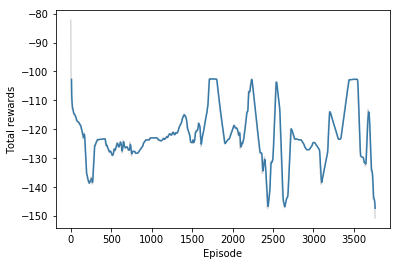

In [106]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

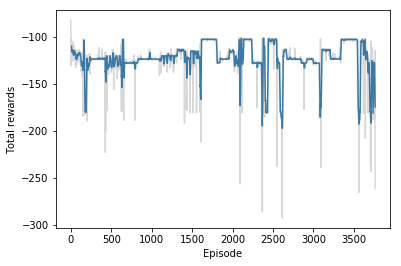

In [107]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

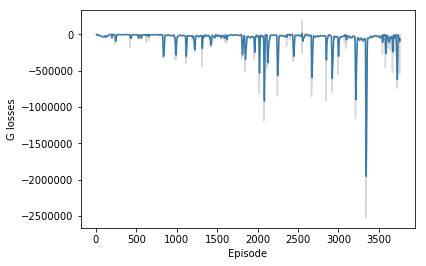

In [108]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

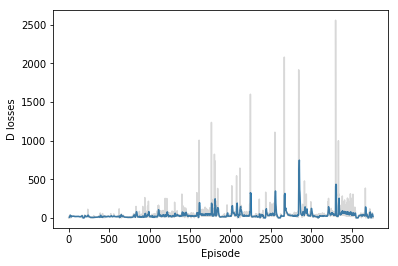

In [109]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [112]:
import gym
env = gym.make('BipedalWalker-v2')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model2.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.reshape(action_logits, [-1]) # For continuous action space
            #action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model2.ckpt
total_reward: -180.71856785841393


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.